In [2]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.1 MB/s eta 0:00:00a 0:00:01


In [4]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import joblib
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/irinaborovskih/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

⏳ Загрузка данных...


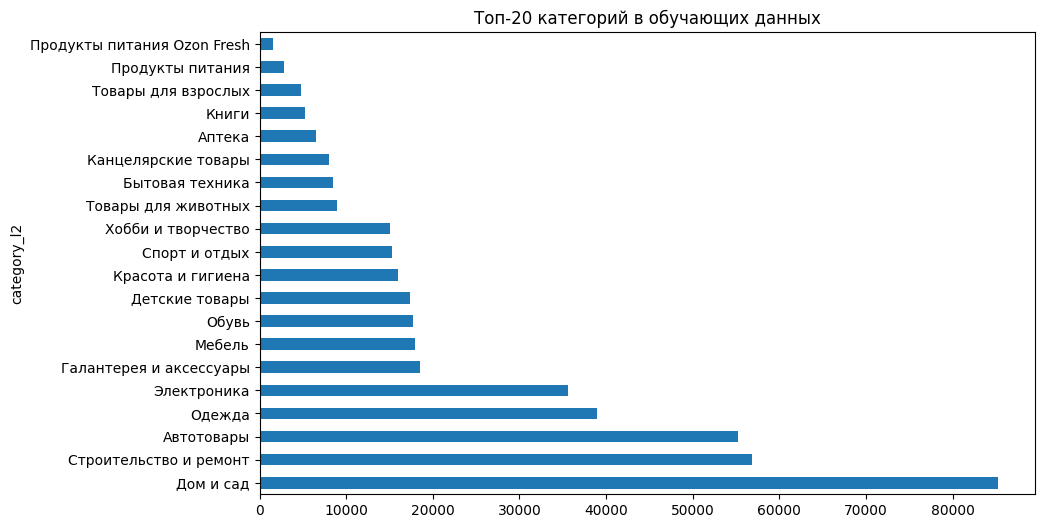

In [5]:
# 2. ЗАГРУЗКА ДАННЫХ
# ======================
print("⏳ Загрузка данных...")
train_data = pd.read_parquet("hackaton_train_types_recom.parquet")
test_data = pd.read_parquet("hackaton_test_types_recom.parquet")

# Визуализация распределения категорий
plt.figure(figsize=(10, 6))
train_data['category_l2'].value_counts()[:20].plot(kind='barh')
plt.title('Топ-20 категорий в обучающих данных')
plt.show()

In [8]:
# 2. ПРЕДОБРАБОТКА ДАННЫХ
# ======================
def remove_duplicates_with_report(df, df_name=""):
    """Удаляет дубликаты и выводит отчет"""
    initial_len = len(df)
    duplicates = df[df.duplicated(keep='first')]
    dup_count = len(duplicates)
    
    if dup_count > 0:
        print(f"\n🔍 Найдено дубликатов в {df_name}: {dup_count} ({dup_count/initial_len:.1%})")
        print("Распределение по категориям:")
        print(duplicates['category_l2'].value_counts().head(10))
        df = df.drop_duplicates()
        print(f"Оставлено записей: {len(df)} (удалено {dup_count})")
    else:
        print(f"\n✅ В {df_name} дубликатов не найдено")
    
    return df

print("\n🧹 Очистка данных...")

# Фильтрация по target
train_data = train_data[train_data["target"] == 1]
test_data = test_data[test_data["target"] == 1]

# Удаление дубликатов
train_data = remove_duplicates_with_report(train_data, "тренировочных данных")
test_data = remove_duplicates_with_report(test_data, "тестовых данных")

# Очистка текста
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Удаляем пунктуацию
    text = re.sub(r'\d+', '', text)      # Удаляем цифры
    return text.strip()

train_data["clean_name"] = train_data["name"].apply(preprocess_text)
test_data["clean_name"] = test_data["name"].apply(preprocess_text)

# Кодирование категорий
le = LabelEncoder()
train_data["category_encoded"] = le.fit_transform(train_data["category_l2"])
test_data["category_encoded"] = le.transform(test_data["category_l2"])  


🧹 Очистка данных...

✅ В тренировочных данных дубликатов не найдено

✅ В тестовых данных дубликатов не найдено


In [9]:
# 3. ВЕКТОРИЗАЦИЯ ТЕКСТА
# ======================
print("\n🔠 Векторизация текста...")
tfidf = TfidfVectorizer(
    max_features=15000,
    stop_words=stopwords.words('russian'),
    ngram_range=(1, 2),
    min_df=3
)

X_train = tfidf.fit_transform(train_data["clean_name"])
X_test = tfidf.transform(test_data["clean_name"])
y_train = train_data["category_encoded"]
y_test = test_data["category_encoded"]


🔠 Векторизация текста...


In [13]:
# 4. ОПТИМИЗАЦИЯ С OPTUNA
# ========================
from sklearn.metrics import accuracy_score  
import optuna
from optuna.samplers import TPESampler
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'verbosity': -1  # Добавляем управление логгированием через этот параметр
    }
    
    model = LGBMClassifier(**params, random_state=42)
    
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    model.fit(
        X_train_sub, y_train_sub,
        eval_set=[(X_val, y_val)],
        callbacks=[
            early_stopping(50),
            log_evaluation(0)  # 0 означает отсутствие логов
        ]
        # Убрали параметр verbose
    )
    
    y_pred = model.predict(X_val)
    return accuracy_score(y_val, y_pred)
print("\n🔎 Оптимизация гиперпараметров (может занять время)...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=50, timeout=7200)

print("\n🏆 Лучшие параметры:")
for key, value in study.best_params.items():
    print(f"{key:>20}: {value}")
print(f"\nBest accuracy: {study.best_value:.4f}")

[I 2025-07-27 15:26:09,154] A new study created in memory with name: no-name-7c7ca79c-ff85-4dc4-af61-c5e4caac6c13



🔎 Оптимизация гиперпараметров (может занять время)...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[574]	valid_0's multi_logloss: 0.694584


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-27 15:30:11,692] Trial 0 finished with value: 0.7954057058169692 and parameters: {'n_estimators': 574, 'learning_rate': 0.2536999076681772, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.7954057058169692.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1170]	valid_0's multi_logloss: 0.650981


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-27 15:33:17,203] Trial 1 finished with value: 0.8021193034457207 and parameters: {'n_estimators': 1170, 'learning_rate': 0.16967533607196555, 'num_leaves': 47, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'reg_alpha': 4.319450186421157, 'reg_lambda': 2.9122914019804194, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.8021193034457207.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid_0's multi_logloss: 0.74096


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-27 15:36:12,951] Trial 2 finished with value: 0.7825120414968507 and parameters: {'n_estimators': 492, 'learning_rate': 0.03476649150592621, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.8056937753654446, 'colsample_bytree': 0.836965827544817, 'reg_alpha': 0.46450412719997725, 'reg_lambda': 6.075448519014383, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.8021193034457207.
/opt/anaconda3/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.wa

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[459]	valid_0's multi_logloss: 0.77226


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-27 16:12:38,450] Trial 4 finished with value: 0.7765542793627269 and parameters: {'n_estimators': 459, 'learning_rate': 0.09519754482692679, 'num_leaves': 60, 'max_depth': 8, 'min_child_samples': 57, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'reg_alpha': 7.7513282336111455, 'reg_lambda': 9.394989415641891, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.8037198962578733.
/opt/anaconda3/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.war

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[274]	valid_0's multi_logloss: 0.825404


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-27 16:46:02,635] Trial 7 finished with value: 0.7634827713968136 and parameters: {'n_estimators': 274, 'learning_rate': 0.0338452204120114, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 64, 'subsample': 0.7323592099410596, 'colsample_bytree': 0.6254233401144095, 'reg_alpha': 3.109823217156622, 'reg_lambda': 3.2518332202674705, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.8037198962578733.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1088]	valid_0's multi_logloss: 0.739946


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-27 16:49:54,892] Trial 8 finished with value: 0.7822156354205261 and parameters: {'n_estimators': 1088, 'learning_rate': 0.049833191601257244, 'num_leaves': 35, 'max_depth': 10, 'min_child_samples': 78, 'subsample': 0.8245108790277985, 'colsample_bytree': 0.9083868719818244, 'reg_alpha': 4.937955963643907, 'reg_lambda': 5.227328293819941, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.8037198962578733.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[307]	valid_0's multi_logloss: 1.07648


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-07-27 16:51:08,538] Trial 9 finished with value: 0.7104409040385328 and parameters: {'n_estimators': 307, 'learning_rate': 0.011128194768838964, 'num_leaves': 103, 'max_depth': 6, 'min_child_samples': 53, 'subsample': 0.9630265895704372, 'colsample_bytree': 0.69971689165955, 'reg_alpha': 4.103829230356297, 'reg_lambda': 7.555511385430487, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.8037198962578733.
/opt/anaconda3/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn


🏆 Лучшие параметры:
        n_estimators: 1149
       learning_rate: 0.26690431824362526
          num_leaves: 125
           max_depth: 6
   min_child_samples: 14
           subsample: 0.8736932106048627
    colsample_bytree: 0.7760609974958406
           reg_alpha: 1.2203823484477883
          reg_lambda: 4.951769101112702
       boosting_type: dart

Best accuracy: 0.8037


In [14]:
# 5. ФИНАЛЬНАЯ МОДЕЛЬ
# ====================
print("\n🤖 Обучение финальной модели...")
best_params = study.best_params
final_model = LGBMClassifier(**best_params, random_state=42)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[early_stopping(50), log_evaluation(50)]
)



🤖 Обучение финальной модели...


/opt/anaconda3/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	valid_0's multi_logloss: 0.89812
[100]	valid_0's multi_logloss: 0.846289
[150]	valid_0's multi_logloss: 0.824988
[200]	valid_0's multi_logloss: 0.816278
[250]	valid_0's multi_logloss: 0.781665
[300]	valid_0's multi_logloss: 0.761439
[350]	valid_0's multi_logloss: 0.745461
[400]	valid_0's multi_logloss: 0.73975
[450]	valid_0's multi_logloss: 0.73723
[500]	valid_0's multi_logloss: 0.712874
[550]	valid_0's multi_logloss: 0.704204
[600]	valid_0's multi_logloss: 0.698083
[650]	valid_0's multi_logloss: 0.680983
[700]	valid_0's multi_logloss: 0.670956
[750]	valid_0's multi_logloss: 0.659141
[800]	valid_0's multi_logloss: 0.652041
[850]	valid_0's multi_logloss: 0.641539
[900]	valid_0's multi_logloss: 0.63688
[950]	valid_0's multi_logloss: 0.636989
[1000]	valid_0's multi_logloss: 0.630308
[1050]	valid_0's multi_logloss: 0.626437
[1100]	valid_0's multi_logloss: 0.617744


,boosting_type,'dart'
,num_leaves,125
,max_depth,6
,learning_rate,0.26690431824362526
,n_estimators,1149
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,14


In [15]:
# 6. ОЦЕНКА И СОХРАНЕНИЕ
# ========================
print("\n📊 Оценка модели...")
y_pred = final_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix (топ-10 категорий):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_[:10]
)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Матрица ошибок (топ-10 категорий)")
plt.tight_layout()
plt.show()

print("\n💾 Сохранение артефактов...")
joblib.dump(final_model, 'best_lgbm_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("\n✅ Готово! Модель сохранена в best_lgbm_model.pkl")


📊 Оценка модели...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Classification Report:


TypeError: object of type 'NoneType' has no len()

In [16]:
# 1. Убедимся, что LabelEncoder правильно обучен
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_data["category_l2"])
y_test_encoded = le.transform(test_data["category_l2"])

# 2. Проверим, что классы существуют
print("Классы в LabelEncoder:", le.classes_)

# 3. Исправленный вывод classification_report
try:
    print("\nClassification Report:")
    print(classification_report(
        y_test_encoded, 
        y_pred,
        target_names=le.classes_.astype(str)  # Явное преобразование в строку
    ))
except Exception as e:
    print("\nОшибка при выводе отчета:", e)
    print("Простой отчет без имен классов:")
    print(classification_report(y_test_encoded, y_pred))

Классы в LabelEncoder: ['Автомототехника' 'Автотовары' 'Антиквариат и коллекционирование'
 'Аптека' 'Бытовая техника' 'Бытовая химия' 'Галантерея и аксессуары'
 'Детские товары' 'Дом и сад' 'Канцелярские товары'
 'Кино, музыка, видеоигры, софт' 'Книги' 'Красота и гигиена' 'Мебель'
 'Музыкальные инструменты' 'Обувь' 'Одежда' 'Продукты питания'
 'Продукты питания Ozon Fresh' 'Спорт и отдых' 'Строительство и ремонт'
 'Товары для взрослых' 'Товары для животных'
 'Товары для курения и аксессуары' 'Фермерское хозяйство'
 'Хобби и творчество' 'Электроника' 'Ювелирные изделия' None]

Classification Report:
                                  precision    recall  f1-score   support

                 Автомототехника       1.00      0.88      0.94        25
                      Автотовары       0.95      0.87      0.91      8933
Антиквариат и коллекционирование       0.69      0.36      0.47       117
                          Аптека       0.76      0.37      0.50       540
                 Бытова